In [1]:
from sklearn.datasets import fetch_olivetti_faces
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn

In [26]:
def plot(X):
  fig, axis = plt.subplots(1, 10, figsize=(15, 1.5))
  for img, ax in zip(X, axis):
    ax.imshow(img.reshape(64, 64), cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])
  plt.show()

In [2]:
data = fetch_olivetti_faces()["images"]

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data


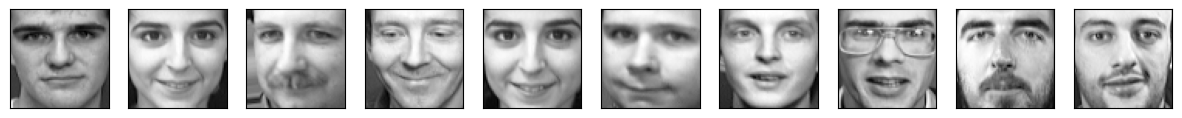

In [27]:
plot(data[np.random.choice(len(data), 10, replace=False)])

In [4]:
data = torch.tensor(data.reshape((-1, 1, 64, 64))).to(torch.float32)

In [20]:
def train(X, model, loss_fn, optimizer, batch_size):
  model.train()
  for i in range(len(X) // batch_size):
    optimizer.zero_grad()
    pred, means, log_s = model(X)
    loss = loss_fn(pred, X, means, log_s)
    loss.backward()
    optimizer.step()

In [32]:
def evaluate(X, model, loss_fn, epoch):
  pred, means, log_s = model(X)
  loss = loss_fn(pred, X, means, log_s).item()
  print(f"Epoch: {epoch} Loss: {round(loss, 4)}")
  plot(pred[:10].detach())

In [6]:
class Transform(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, X):
        return torch.reshape(X, (-1, 8, 16, 16))

In [16]:
class Sample(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, means, log_s):
        return torch.exp(log_s) * torch.rand_like(log_s) + means

In [18]:
class CustomLoss(nn.Module):
  def __init__(self):
    super(CustomLoss, self).__init__()
    self.BCE_Loss = nn.BCELoss(reduction="sum")

  def forward(self, predictions, target, means, log_s):
    kl_loss = -0.5 * torch.sum(1 + log_s - means**2 - torch.exp(log_s))
    return self.BCE_Loss(predictions, target) + kl_loss

In [59]:
class VAE(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Conv2d(1, 8, (3, 3), padding=1, stride=2),
        nn.ReLU(),
        nn.Conv2d(8, 8, (3, 3), padding=1, stride=2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(2048, 256),
        nn.ReLU()
    )

    self.means = nn.Linear(256, 16)
    self.log_s = nn.Linear(256, 16)
    self.sample = Sample()

    self.decoder = nn.Sequential(
        nn.Linear(16, 256),
        nn.ReLU(),
        nn.Linear(256, 2048),
        nn.ReLU(),
        Transform(),
        nn.Conv2d(8, 8, (3, 3), padding=1),
        nn.Upsample(scale_factor=2),
        nn.ReLU(),
        nn.Conv2d(8, 1, (3, 3), padding=1),
        nn.Upsample(scale_factor=2),
        nn.Sigmoid()
    )

  def forward(self, X):
    encoded = self.encoder(X)
    means = self.means(encoded)
    log_s = self.log_s(encoded)
    sampled = self.sample(means, log_s)
    decoded = self.decoder(sampled)
    return decoded, means, log_s

In [62]:
model = VAE()
loss_fn = CustomLoss()
optimizer = torch.optim.Adam(model.parameters())

Epoch: 1 Loss: 1119513.625


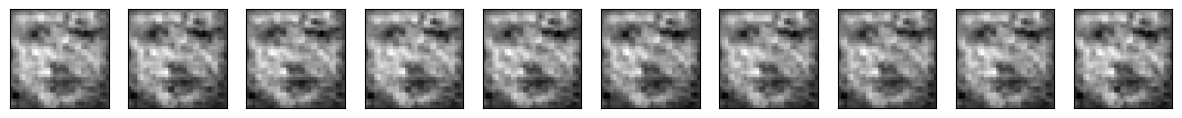

Epoch: 21 Loss: 1074400.375


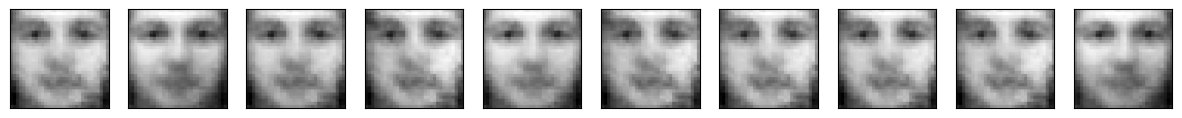

Epoch: 41 Loss: 1061210.625


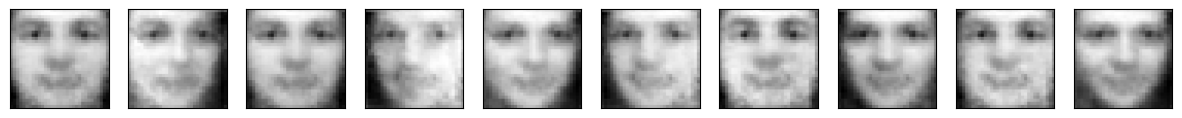

Epoch: 61 Loss: 1056424.0


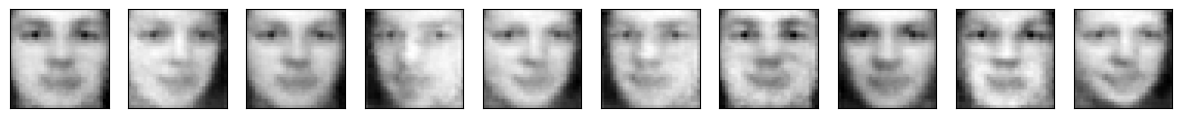

Epoch: 81 Loss: 1052247.625


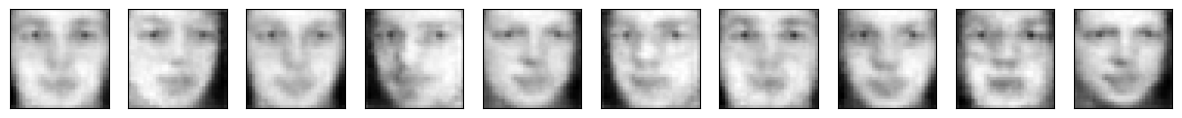

Epoch: 101 Loss: 1048901.625


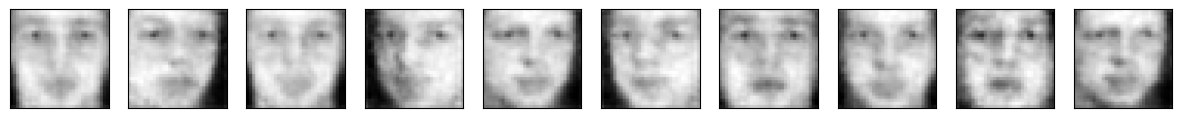

In [63]:
for i in range(101):
  train(data, model, loss_fn, optimizer, 100)
  if i % 20 == 0:
    evaluate(data, model, loss_fn, i + 1)

In [64]:
pred_means = model.means(model.encoder(data))
pred_ls = model.log_s(model.encoder(data))

In [65]:
min_m = torch.min(pred_means, axis=0)[0].detach()
max_m = torch.max(pred_means, axis=0)[0].detach()

min_ls = torch.min(pred_ls, axis=0)[0].detach()
max_ls = torch.max(pred_ls, axis=0)[0].detach()

In [66]:
def generate_samples(minimum, maximum, size):
  samples = []
  for i in range(size):
    samples.append(np.random.uniform(minimum[i], maximum[i], 1)[0])
  return np.array(samples).reshape(size)

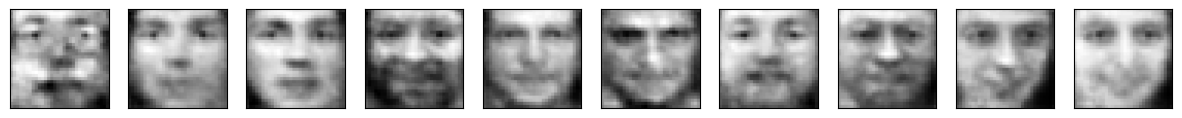

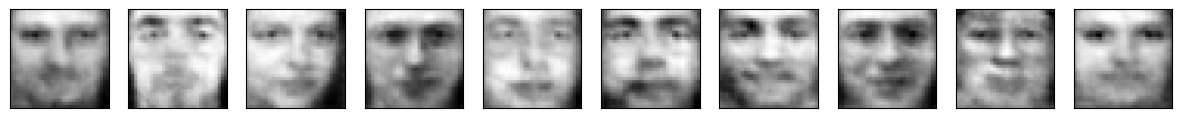

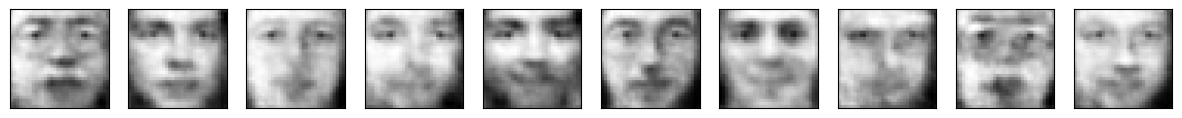

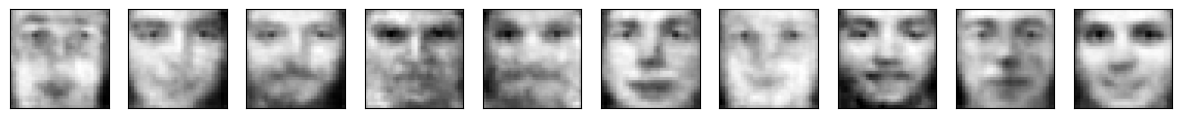

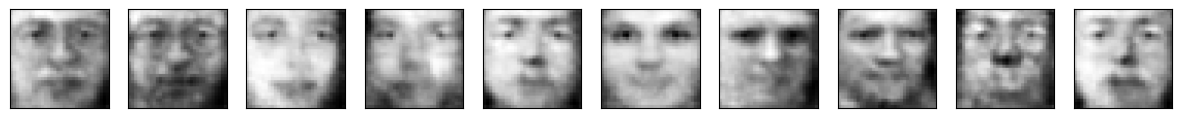

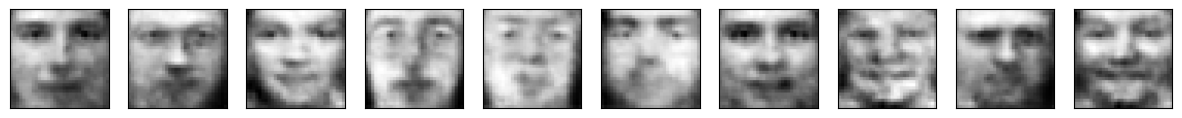

In [67]:
for i in range(6):
  random_latent_means = torch.tensor([generate_samples(min_m, max_m, 16) for i in range(10)]).to(torch.float32)
  random_latent_ls = torch.tensor([generate_samples(min_ls, max_ls, 16) for i in range(10)]).to(torch.float32)
  generated_images = model.decoder(model.sample(random_latent_means, random_latent_ls))
  plot(generated_images.detach())